In [2]:
from astropy.io import fits
import clevar
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
from clevar.match_metrics.distances import ClCatalogFuncs as d_cf
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf
import clevar.match_metrics.scaling as scaling

import pandas as pd
from astropy.table import Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

In [4]:
hdul_halos = fits.open("../halos/halos.fits")
hdul_ame = fits.open("richness_mcut_SNR 12_ame.fits")

logMmin = 13
logMmax = 15

table_halos = hdul_halos[1].data
table_ame = hdul_ame[1].data
table_halos = table_halos[(table_halos['upid'] == -1)  &  (table_halos['Mvir'] >= 10**logMmin) & (table_halos['Mvir'] <= 10**logMmax)]
table_halos['Mvir'] = table_halos['Mvir']/0.6774

print(table_halos.size)
print(table_ame.size)

#print(table_ame.columns)

print("DEC max")
print(table_ame['DEC'].max())
print(table_halos['DEC'].max())
print('\n')
print("DEC min")
print(table_ame['DEC'].min())
print(table_halos['DEC'].min())
print('\n')
print("RA max")
print(table_ame['RA'].max())
print(table_halos['RA'].max())
print('\n')
print("RA min")
print(table_ame['RA'].min())
print(table_halos['RA'].min())
print('\n')
print("z max")
print(table_ame['z'].max())
print(table_halos['redshift_R'].max())
print('\n')
print("z min")
print(table_ame['z'].min())
print(table_halos['redshift_R'].min())

689973
23751
DEC max
69.987462659708
69.99966430664062


DEC min
20.00571528380776
20.00000762939453


RA max
229.99483480331588
229.99951171875


RA min
110.00560235552096
110.00007629394531


z max
0.6587940911577925
0.6646281966028926


z min
0.0462011092646255
0.00388302828285513


In [3]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_ame = clevar.ClCatalog('Detection catalog', ra=table_ame['RA'], dec=table_ame['DEC']
                             , z=table_ame['z'], mass=table_ame['R_ame']  , mass_err=table_ame['R_ame_err'] ,z_err=table_ame['z_err'] , )
catalog_ame

/global/u2/l/lettieri/miniforge3/envs/numcosmo_developer/lib/python3.12/site-packages/clevar-0.15.3-py3.12.egg/clevar/catalog/tagdata.py:278: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")


In [4]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'redshift_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':0.01,
                'match_radius': '100 arcsec'
                },
    'catalog2': {'delta_z':0.01,
                'match_radius': '100 arcsec'
                }
}

cosmo_astropy = clevar.cosmology.AstroPyCosmology()

#mt.match_from_config(catalog_halos, catalog_ame, match_config, cosmo=cosmo_astropy)
#mt.save_matches(catalog_halos, catalog_ame, out_dir='temp', overwrite=True)

In [5]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_ame = clevar.ClCatalog('Detection catalog', ra=table_ame['RA'], dec=table_ame['DEC']
                             , z=table_ame['z'], mass=table_ame['R_ame']  , mass_err=table_ame['R_ame_err'] ,z_err=table_ame['z_err'] , )
mt = clevar.match.ProximityMatch()
mt.load_matches(catalog_halos, catalog_ame, out_dir='temp')

halos_match, detections_match = clevar.match.get_matched_pairs(catalog_halos, catalog_ame, 'cross')

display(detections_match)

Halo catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    689,973
 * multiple (self):  25,922
 * multiple (other): 25,922
 * unique (self):    22,285
 * unique (other):   22,285
 * cross:            22,271

Detection catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    23,751
 * multiple (self):  22,285
 * multiple (other): 22,285
 * unique (self):    22,285
 * unique (other):   22,285
 * cross:            22,271


In [6]:
halos_match

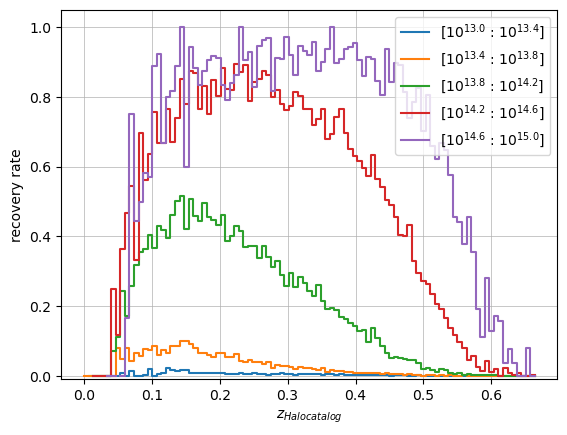

In [7]:
from clevar.match_metrics import recovery
zbins = np.linspace(0.0, 0.664, 100)
mbins = np.logspace(13.0, 15, 6)
info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
plt.legend()
plt.savefig("recovery_halos_z.jpg")
info['data']['recovery']
plt.show()
m_plot = []

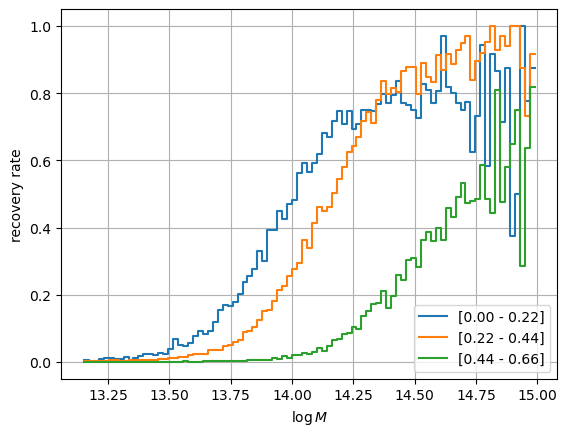

In [14]:
zbins = np.linspace(0.0, 0.664, 2)
mbins = np.logspace(13.0, 15, 100)

#info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
m_plot = []
for i in range(len(mbins)-1):
    m_plot.append((np.log10(mbins[i])+np.log10(mbins[i+1]))/2)
for j in range(len(zbins)-1):
    
    plt.step(m_plot , info['data']['recovery'][j] , label='[%.2f - %.2f]' % (zbins[j],zbins[j+1]))
    
plt.legend(loc=4)
plt.xlabel(r"$\log M$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_halos_mass.jpg")

<NumCosmoMath.Spline2dBicubic object at 0x7f89d00075c0 (NcmSpline2dBicubic at 0x561cb4229a60)>

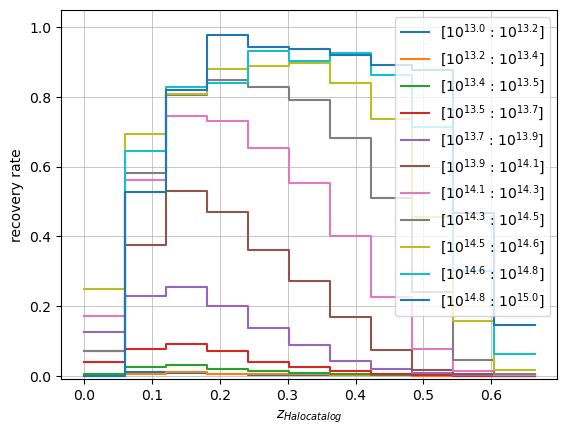

In [9]:
import selection
zbins = np.linspace(0.0, 0.664, 12)
mbins = np.logspace(13.0, 15, 12)
selection_ame = selection.NcClusterSelectionFunction()
info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
z = Ncm.Vector.new(len(zbins)-1)
lnM = Ncm.Vector.new(len(mbins)-1)
completeness = Ncm.Matrix.new(len(zbins)-1 , len(mbins)-1)
for i in range(z.len()):
    z.set(i , (zbins[i]+zbins[i+1])/2)

for i in range(lnM.len()):
    lnM.set(i , (np.log(mbins[i])+np.log(mbins[i+1]))/2)

    
for i in range(z.len()):
    for j in range(lnM.len()):
        completeness.set(i , j , info['data']['recovery'][j][i])
selection_ame.nc_cluster_selection_function_completeness(z , lnM , completeness)


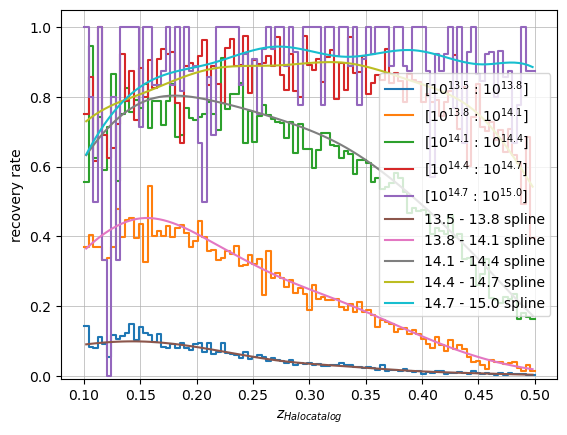

0.7250800723395187


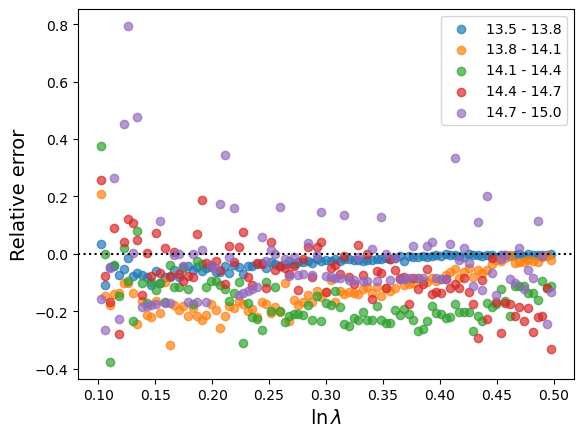

In [10]:
from clevar.match_metrics import recovery
import math
zbins = np.linspace(0.1, 0.5, 100)
mbins = np.logspace(13.5, 15, 6)
info = recovery.plot(catalog_halos, 'cross', zbins, mbins, shape='steps')

for i in range(len(mbins)-1):
    z_plot = []
    completeness = []
    completeness_i = []
    completeness_analytical = []
    for j in range(len(zbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_completeness_eval((zbins[j]+zbins[j+1])/2, 
        (np.log(mbins[i])+np.log(mbins[i+1]))/2))
        z_plot.append((zbins[j]+zbins[j+1])/2)
        
    plt.plot(z_plot , completeness, label="%.1f - %.1f spline" % (np.log10(mbins[i]),np.log10(mbins[i+1])))
    
plt.legend()
plt.show()



for i in range(len(mbins)-1):
    completeness = []
    diff = []
    for j in range(len(zbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_completeness_eval((zbins[j]+zbins[j+1])/2 , np.log(mbins[i]) ))
        diff.append((completeness[j]-info['data']['recovery'][j-1][i]))
    plt.scatter(z_plot, diff, alpha=0.6774, label="%.1f - %.1f" % (np.log10(mbins[i]),np.log10(mbins[i+1])))
plt.legend()
plt.xlabel(r'$\ln\lambda$', size=14)
plt.ylabel('Relative error', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted') 
print(selection_ame.nc_cluster_selection_function_completeness_integ(zbins[0], zbins[-1], np.log(mbins[0]) , np.log(mbins[-1])))

ValueError: x and y must have same first dimension, but have shapes (99,) and (5,)

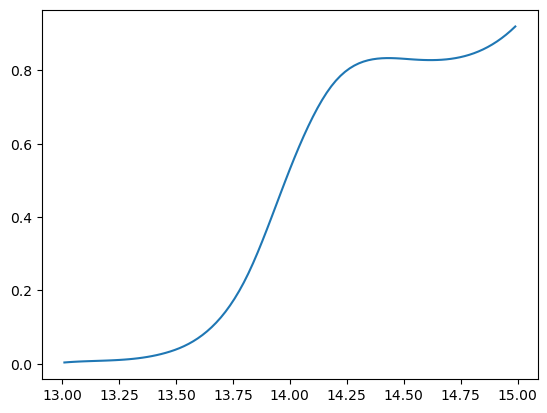

In [11]:
from clevar.match_metrics import recovery

zbins = np.linspace(0.1, 0.5, 4)
mbins = np.logspace(13.0, 15, 100)
rbins = np.logspace(0 , 3, 2)
#info = recovery.plot(catalog_halos, 'cross', zbins, mbins, shape='steps')
plt.show()
for i in range(len(zbins)-1):
    lnM_plot = []
    completeness = []
    for j in range(len(mbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_completeness_eval((zbins[i]+zbins[i+1])/2, 
        (np.log(mbins[j])+np.log(mbins[j+1]))/2))
        lnM_plot.append((np.log10(mbins[j])+np.log10(mbins[j+1]))/2)
    plt.plot(lnM_plot , completeness, label="[%.2f - %.2f] interpol" % (zbins[i],zbins[i+1]))   
    
    plt.step(lnM_plot , info['data']['recovery'][i] , label='[%.2f - %.2f] data' % (zbins[i],zbins[i+1]))
    #print( info['data']['recovery'])
    
    
plt.legend()

In [ ]:
zbins = np.linspace(0.0, 0.664, 2)
rbins = np.logspace(0, 3, 2)

info = recovery.plot(catalog_ame, 'multi_other', zbins, rbins, shape='steps')

plt.legend()
plt.savefig("recovery_detections_z.jpg")
print(info)


In [ ]:
zbins = np.linspace(0.0, 0.664, 2)
rbins = np.logspace(1.1 , 2.3 100)

#info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
r_plot = []
for i in range(len(rbins)-1):
    r_plot.append((np.log(rbins[i])+np.log(rbins[i+1]))/2)
for j in range(len(zbins)-1):
    
    plt.step(r_plot , info['data']['recovery'][j] , label='[%.2f - %.2f]' % (zbins[j],zbins[j+1]))
    
plt.legend(loc=3)
plt.xlabel(r"$\ln \lambda$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_detections_rich.jpg")

In [ ]:
zbins = np.linspace(0.1, 0.5, 7)
rbins = np.logspace(1.3 , 2.3, 7)

info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
z = Ncm.Vector.new(len(zbins)-1)
lnR = Ncm.Vector.new(len(rbins)-1)
purity = Ncm.Matrix.new(len(zbins)-1 , len(rbins)-1)
for i in range(z.len()):
    z.set(i , (zbins[i]+zbins[i+1])/2)

for i in range(lnR.len()):
    lnR.set(i , (np.log(rbins[i])+np.log(rbins[i+1]))/2)

    
for i in range(z.len()):
    for j in range(lnR.len()):
        purity.set(i , j , info['data']['recovery'][j][i])
selection_ame.nc_cluster_selection_function_purity(z , lnR , purity)

info['data']

In [ ]:
from clevar.match_metrics import recovery
import math
zbins = np.linspace(0.1, 0.5, 100)
rbins = np.logspace(1.3 , 2.3, 7)

info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')

for i in range(len(rbins)-1):
    z_plot = []
    purity = []

    for j in range(len(zbins)-1):
        purity.append(selection_ame.nc_cluster_selection_function_purity_eval((zbins[j]+zbins[j+1])/2, 
        (np.log(rbins[i])+np.log(rbins[i+1]))/2))
        z_plot.append((zbins[j]+zbins[j+1])/2)
        
    plt.plot(z_plot , purity, label="%.1f - %.1f spline" % (np.log10(rbins[i]),np.log10(rbins[i+1])))
    
plt.legend()
plt.show()



for i in range(len(rbins)-1):
    completeness = []
    diff = []
    for j in range(len(zbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_purity_eval((zbins[j]+zbins[j+1])/2 , np.log(rbins[i]) ))
        diff.append((completeness[j]-info['data']['recovery'][j-1][i]))
    plt.scatter(z_plot, diff, alpha=0.6774, label="%.1f - %.1f" % (np.log10(rbins[i]),np.log10(rbins[i+1])))
plt.legend()
plt.xlabel(r'$\ln\lambda$', size=14)
plt.ylabel('Relative error', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted') 
print(selection_ame.nc_cluster_selection_function_completeness_integ(zbins[0], zbins[-1], np.log(rbins[0]) , np.log(rbins[-1])))

In [ ]:
from clevar.match_metrics import recovery

zbins = np.linspace(0.1, 0.5, 4)
rbins = np.logspace(1.3 , 2.3, 100)
#info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
plt.show()
for i in range(len(zbins)-1):
    lnR_plot = []
    completeness = []
    for j in range(len(rbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_purity_eval((zbins[i]+zbins[i+1])/2, 
        (np.log(rbins[j])+np.log(rbins[j+1]))/2))
        lnR_plot.append((np.log10(rbins[j])+np.log10(rbins[j+1]))/2)
    plt.plot(lnR_plot , completeness, label="[%.2f - %.2f] interpol" % (zbins[i],zbins[i+1]))   
    
    plt.step(lnR_plot , info['data']['recovery'][i] , label='[%.2f - %.2f] data' % (zbins[i],zbins[i+1]))
    #print( info['data']['recovery'])
    
    
plt.legend()

In [ ]:
catalog_ame_random = clevar.ClCatalog('Detection catalog', ra=table_ame['RA'], dec=table_ame['DEC']
                             , z=table_ame['z'], mass=table_ame['R_ame']  , mass_err=table_ame['R_ame_err'] ,z_err=table_ame['z_err'] , )

for i in range(len(catalog_ame_random["RA"])):
    catalog_ame_random["RA"][i] +=10
    if catalog_ame_random["RA"][i] >230:
       
       catalog_ame_random["RA"][i] -= 120

In [ ]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'angular_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':0.01,
                'match_radius': '100 arcsec'
                },
    'catalog2': {'delta_z':0.01,
                'match_radius': '100 arcsec'
                }
}

cosmo_astropy = clevar.cosmology.AstroPyCosmology()

mt.match_from_config(catalog_halos, catalog_ame_random, match_config, cosmo=cosmo_astropy)
mt.save_matches(catalog_halos, catalog_ame_random, out_dir='temp_random', overwrite=True)